In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from scipy.special import kv
import xray_analysis as xray
import sys,os
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from scipy.interpolate import interp1d, RectBivariateSpline
from beam_fitting import GP_beam_fitter


import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    with open(filename, 'rb') as fid:
        return pickle.load(fid)


def imagesc(I,ax = None,  x=None, y=None, **kwargs):
    """ display image with axes using pyplot
    recreates matlab imagesc functionality (roughly)
    argument I = 2D numpy array for plotting
    kwargs:
        ax = axes to plot on, if None will make a new one
        x = horizontal  axis - just uses first an last values to set extent
        y = vetical axis like x
        **kwargs anthing else which is passed to imshow except extent and aspec which are set
    """
    if ax is None:
        plt.figure()
        ax = plt.axes()
    if x is None:
        Nx = np.size(I, axis=1)
        x = np.arange(Nx)
    if y is None:
        Ny = np.size(I, axis=0)
        y = np.arange(Ny)
    ext = (x[0], x[-1], y[-1], y[0])
    return ax.imshow(I, extent=ext, aspect='auto', **kwargs)

BASE_PATH =r'/Users/streeter/BoxSync/Experiments/GeminiXANES2020/MIRAGE/'
from PIL import Image
def load_lundatron(file_path):
    return np.array(Image.open(file_path)).astype(float)

def lundatron_file2signal(file_path,bkg):
    img_raw = load_lundatron(img_file)  
    img_sub = img_raw -bkg
    return median_filter(img_sub,(3, 3))
    


In [2]:

file_path = 'filter_masks/20200827_run09_Lundatron_filter_masks.pkl'
mask_obj=load_object( file_path)
run_name_pref = '20200827_run09'
filter_filepath = 'transmission_functions/' +  run_name_pref +'_Lundatron_filter_pack.pkl'
filter_obj = load_object(filter_filepath)
BF = GP_beam_fitter(mask_obj['beam_mask'],N_samples = 1000)


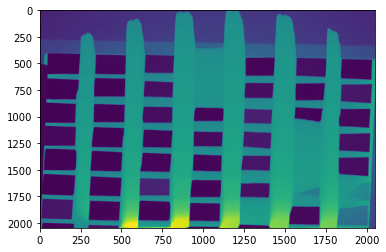

In [26]:
bkg_file = '/Users/streeter/BoxSync/Experiments/GeminiXANES2020/MIRAGE/Lundatron/20200827/run05/Shot001.tif'
run_name = '20200827/run09'
shot_num = 5
shot_file = os.path.join(run_name,f'Shot{shot_num:03}.tif')
img_file = os.path.join(BASE_PATH,'Lundatron/',shot_file)


img_bkg = load_lundatron(bkg_file)
img_sub = lundatron_file2signal(img_file,img_bkg)

imagesc(img_sub)

Null transmission mean = 0.999803
Null transmission rms = 0.041385


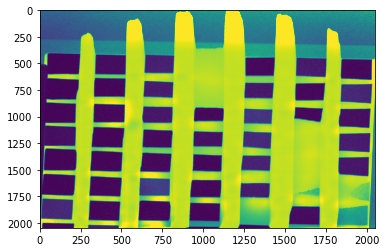

In [27]:
beam_estimate,beam_uncertainty = BF.fit_beam(img_sub,med_filter=None)
transmission_img = img_sub/beam_estimate
imagesc(transmission_img,vmax=1.1)

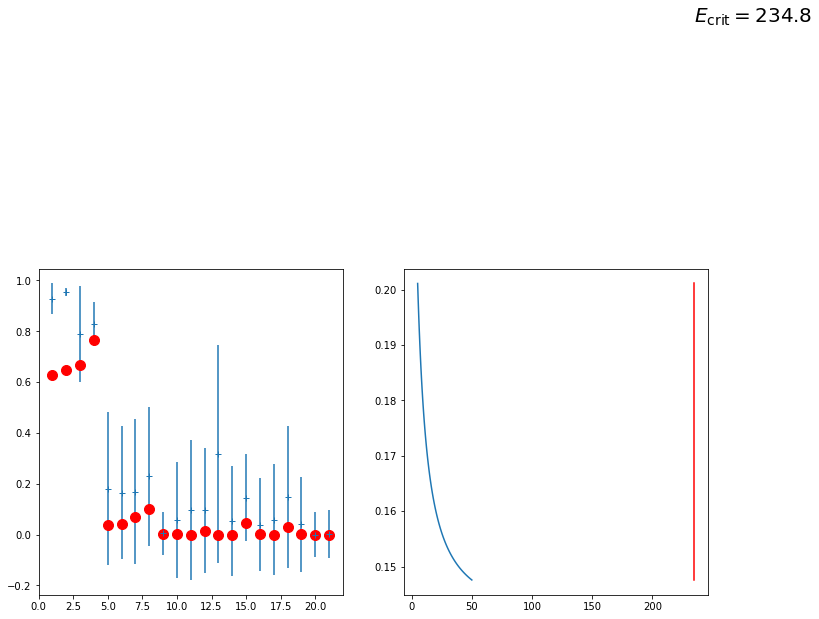

In [28]:

B_fitter = xray.Betatron_spec_fitter(transmission_img,filter_obj,mask_obj)
B_fitter.measured_trans = B_fitter.measured_trans-np.min(B_fitter.measured_trans)
Ec_opt, trans_pred = B_fitter.calc_E_crit()
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].errorbar(B_fitter.filter_number,B_fitter.measured_trans,B_fitter.measured_trans_rms,
               fmt='+')
axs[0].plot(B_fitter.filter_number, trans_pred ,'ro',ms=10)
       
Ec_array = np.linspace(5,50,num=100)
trans_err = []
for Ec in Ec_array:
    trans_err.append(B_fitter.err_func(Ec))
axs[1].plot(Ec_array,trans_err)
axs[1].plot((Ec_opt,Ec_opt),(np.min(trans_err),np.max(trans_err)),'r-')
axs[1].text(Ec_opt,np.min(trans_err)+np.max(trans_err)/2,
            r'$E_{\mathrm{crit}} = $' + f'{Ec_opt:3.1f}',
            fontdict = {'fontsize':20});
